In [1]:
# === System & OS Utilities ===
import os
import random
import math
import pickle
import sys
import warnings
warnings.filterwarnings("ignore")

# === Progress Bar ===
from tqdm import tqdm

# === TensorFlow & Keras ===
import tensorflow as tf
from tensorflow.keras.models import Model, load_model

from tensorflow.keras.layers import (
    Layer, Conv2D, Dense, Dropout,
    GlobalAveragePooling2D, GlobalMaxPooling2D,
    Reshape, Multiply, Add, Activation, Concatenate
)
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

# === Data Handling ===
import numpy as np
import pandas as pd
import cv2

# === Visualization ===
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# === Scikit-learn ===
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, classification_report, confusion_matrix
)

In [2]:
print("Python version:", sys.version)
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("OpenCV version:", cv2.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)
print("Scikit-learn version:", sklearn.__version__)

Python version: 3.10.16 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:19:12) [MSC v.1929 64 bit (AMD64)]
TensorFlow version: 2.10.1
Keras version: 2.10.0
NumPy version: 1.26.4
Pandas version: 2.2.3
OpenCV version: 4.11.0
Matplotlib version: 3.10.3
Seaborn version: 0.13.2
Scikit-learn version: 1.6.1


> You need to install specific versions of library given below to work with this notebook

The given command will install the following versions:

* Python: 3.11.11 (as per your system)

* TensorFlow: 2.18.0

* Keras: 3.5.0

* NumPy: 1.26.4

* Pandas: 2.2.3

* OpenCV: 4.6.0.66

* Matplotlib: 3.7.5

* Seaborn: 0.12.2

* Scikit-learn: 1.2.2

In [3]:
#python version 3.11.11
#!python -m pip install tensorflow==2.18.0 keras==3.5.0 numpy==1.26.4 pandas==2.2.3 opencv-python==4.6.0.66 matplotlib==3.7.5 seaborn==0.12.2 scikit-learn==1.2.2

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs detected: {len(gpus)}")
    except RuntimeError as e:
        print(f"Error setting GPU memory growth: {e}")
else:
    print("No GPUs detected.")

GPUs detected: 1


In [2]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
EPOCH = 50
img_shape=(*IMG_SIZE,3)
labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#labels = ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'UNK', 'VASC']

In [3]:
def data_frame(path):
    class_paths = []
    classes = []

    for label in os.listdir(path):
        class_dir = os.path.join(path, label)
        if os.path.isdir(class_dir):  
            for image in os.listdir(class_dir):
                class_paths.append(os.path.join(class_dir, image))
                classes.append(label)

    df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return df

In [4]:
#dataframe = data_frame('/kaggle/input/ham1000-aug-resized-organized/HAM10000_organized')
dataframe = data_frame(r'HAM10000_organized')
# First split: 70% train, 30% temp (val + test)
train_dataframe, temp_dataframe = train_test_split(
    dataframe,
    test_size=0.3,
    random_state=42,
    stratify=dataframe['Class']
)

# Second split: 2/3 val, 1/3 test of the 30% => 20% val, 10% test overall
validation_dataframe, test_dataframe = train_test_split(
    temp_dataframe,
    test_size=1/3,
    random_state=42,
    stratify=temp_dataframe['Class']
)

print(f"Train size: {len(train_dataframe)}, Validation size: {len(validation_dataframe)}, Test size: {len(test_dataframe)}")

Train size: 32854, Validation size: 9387, Test size: 4694


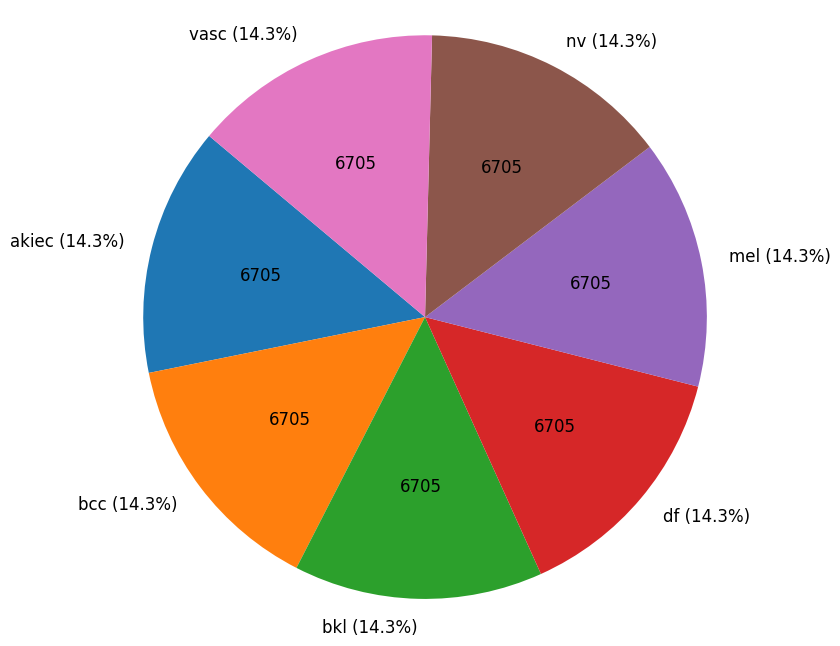

In [5]:
# Count occurrences in each DataFrame
train_counts = train_dataframe['Class'].value_counts()
val_counts = validation_dataframe['Class'].value_counts()
test_counts = test_dataframe['Class'].value_counts()

# Combine and sum the counts
total_counts = train_counts.add(val_counts, fill_value=0)
total_counts = total_counts.add(test_counts, fill_value=0)
total_counts = total_counts.sort_index()

# Prepare labels with percentages
total = total_counts.sum()
labels_with_percent = [f"{label} ({(count/total)*100:.1f}%)" for label, count in zip(total_counts.index, total_counts.values)]

# Define custom autopct function to show raw count
def make_autopct(values):
    def autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f"{count}"
    return autopct

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(total_counts.values, labels=labels_with_percent, autopct=make_autopct(total_counts.values), startangle=140, textprops={'fontsize': 12})
plt.axis('equal')
plt.show()

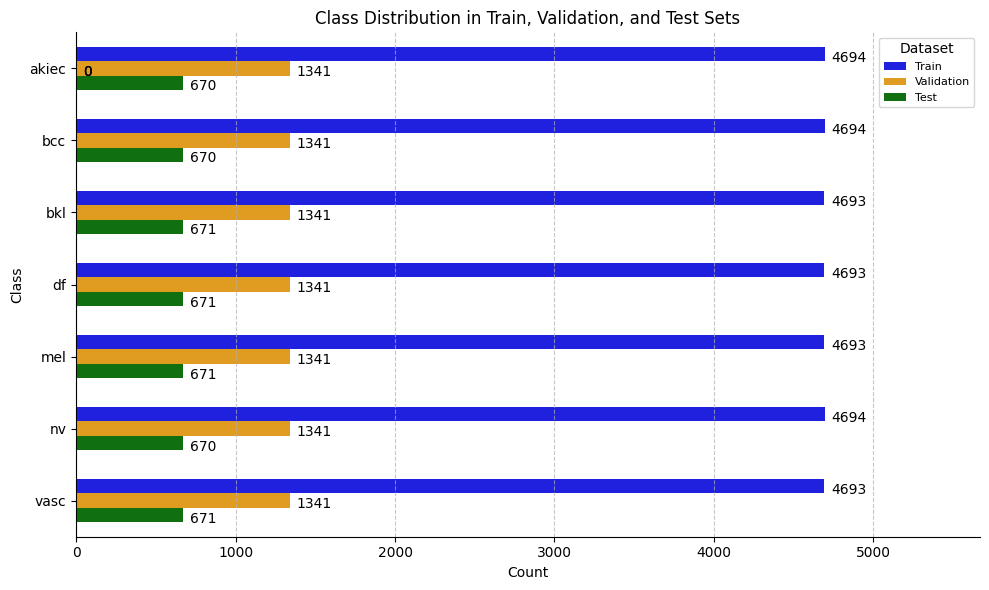

In [10]:
# Count occurrences of each class in train, validation, and test datasets
train_counts = train_dataframe['Class'].value_counts().sort_index()
val_counts = validation_dataframe['Class'].value_counts().sort_index()
test_counts = test_dataframe['Class'].value_counts().sort_index()

# Combine into a DataFrame with the index kept as a column
data_counts = pd.DataFrame({
    'Class': train_counts.index,
    'Train': train_counts.values,
    'Validation': val_counts.values,
    'Test': test_counts.values
}).melt(id_vars='Class', var_name='Dataset', value_name='Count')

# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(y='Class', x='Count', hue='Dataset', data=data_counts, 
                 palette=['blue', 'orange', 'green'], orient='h', width=0.6)

# Add count labels to the right of the bars with slight downward offset
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width(), p.get_y() + p.get_height() / 2.0 + 0.05),  # pushed slightly down
                ha='left', va='center', 
                fontsize=10, color='black', 
                xytext=(5, 0), textcoords='offset points')

# Remove borders (spines)
sns.despine(top=True, right=True, left=False, bottom=False)

# Dynamically set the x-axis limits with some extra space on the right
left, right = ax.get_xlim()  # Get current x-limits

# Set the new right limit with a 15% increase
right += (right - left) * 0.15  # Increase right by 15%

# Apply the new limits to the x-axis
ax.set_xlim(left, right)

# Add labels and title
plt.ylabel("Class")
plt.xlabel("Count")
plt.title("Class Distribution in Train, Validation, and Test Sets")

# Move the legend
plt.legend(title="Dataset", loc='upper right', fontsize=8)

# Add grid only along x-axis
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Tidy layout
plt.tight_layout()
plt.show()

In [10]:
def preprocess_image(image):
    # Convert image to uint8 if needed (required for CLAHE)
    if image.dtype != np.uint8:
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Convert to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

    # Apply CLAHE to the L-channel (lightness)
    clahe = cv2.createCLAHE(clipLimit=0.01, tileGridSize=(8, 8))
    lab[:, :, 0] = clahe.apply(lab[:, :, 0])

    # Convert back to RGB
    image_clahe = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    # Apply Min-Max scaling to [0, 1]
    image_clahe = image_clahe.astype(np.float32)
    image_clahe = (image_clahe - np.min(image_clahe)) / (np.ptp(image_clahe) + 1e-8)  # np.ptp = max - min

    return image_clahe

In [11]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    rotation_range=15,
    zoom_range=0.15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)


train_data = train_datagen.flow_from_dataframe(train_dataframe, x_col='Class Path',
                                  y_col='Class', batch_size=BATCH_SIZE,
                                  target_size=IMG_SIZE, seed=42)

validation_data = val_datagen.flow_from_dataframe(validation_dataframe, x_col='Class Path',
                                     y_col='Class', batch_size=BATCH_SIZE,
                                     target_size=IMG_SIZE, seed=42)

test_data = test_datagen.flow_from_dataframe(test_dataframe, x_col='Class Path',
                                  y_col='Class', batch_size=BATCH_SIZE,
                                  target_size=IMG_SIZE, shuffle=False, seed=42)

Found 32854 validated image filenames belonging to 7 classes.
Found 9387 validated image filenames belonging to 7 classes.
Found 4694 validated image filenames belonging to 7 classes.


In [12]:
@tf.keras.utils.register_keras_serializable(package="Custom", name="F1Score")
class F1Score(tf.keras.metrics.Metric):
    """
    Custom Keras metric to compute the F1 Score.
    The F1 score is the harmonic mean of precision and recall.
    """

    def __init__(self, name='f1_score', **kwargs):
        """
        Initializes the F1Score metric. 
        - Uses Keras' Precision and Recall metrics as intermediate steps.
        """
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()  # Precision metric
        self.recall = tf.keras.metrics.Recall()  # Recall metric

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        Updates the state of the metric.
        - This method is called during training to update precision and recall.
        - The precision and recall states are updated based on true and predicted values.
        """
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        """
        Computes and returns the F1 score.
        - F1 score is calculated as the harmonic mean of precision and recall.
        - Prevents division by zero by adding a small epsilon value to the denominator.
        """
        p = self.precision.result()  # Get precision value
        r = self.recall.result()  # Get recall value
        return 2 * (p * r) / (p + r + tf.keras.backend.epsilon())  # Calculate F1 score

    def reset_states(self):
        """
        Resets the states of the precision and recall metrics.
        - This is called at the beginning of each epoch.
        """
        self.precision.reset_states()  # Reset precision state
        self.recall.reset_states()  # Reset recall state


In [13]:
class RestoreBestValidationModel(Callback):
    """
    Custom Keras Callback to restore model weights from the best epoch based on validation accuracy.
    - Tracks the best validation accuracy during training.
    - Restores the model weights from the epoch with the best validation accuracy when training finishes.
    """
    
    def __init__(self):
        super(RestoreBestValidationModel, self).__init__()
        # Initialize best validation accuracy, epoch, and weights to track the best model
        self.best_val_acc = -1
        self.best_epoch = -1
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        """
        Callback function executed at the end of each epoch.
        - Compares the current validation accuracy with the best validation accuracy.
        - If the current validation accuracy is higher or tied but at a later epoch, updates the best model weights.
        """
        # Get validation accuracy from logs
        val_acc = logs.get('val_accuracy')
        
        if val_acc is not None:
            # Update the best validation accuracy and weights if the current one is better or at a later epoch
            if val_acc > self.best_val_acc or (val_acc == self.best_val_acc and epoch > self.best_epoch):
                self.best_val_acc = val_acc
                self.best_epoch = epoch
                self.best_weights = self.model.get_weights()  # Store the model's weights
                print(f"Model weights updated at epoch {epoch + 1} with val_accuracy: {val_acc:.4f}")

    def on_train_end(self, logs=None):
        """
        Callback function executed at the end of training.
        - Restores the model weights from the epoch with the best validation accuracy.
        """
        # If we found a better model during training, restore the best weights
        if self.best_weights is not None:
            print(f"Restoring model weights from best epoch {self.best_epoch + 1} with val_accuracy: {self.best_val_acc:.4f}")
            self.model.set_weights(self.best_weights)  # Set the weights back to the best model's weights

# Instantiate the callback
restore_best = RestoreBestValidationModel()


In [14]:
# Channel Attention Block
@tf.keras.utils.register_keras_serializable(package="Custom", name="ChannelAttention")
class ChannelAttention(Layer):
    """
    Channel Attention Block (CA) that computes channel-wise attention.
    
    Args:
        reduction: The factor for reducing the number of channels in the intermediate layer.
    """
    def __init__(self, reduction=16, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.reduction = reduction

    def build(self, input_shape):
        """
        Build the dense layers for the Channel Attention mechanism.
        - `shared_dense_one`: reduces channel dimensions.
        - `shared_dense_two`: restores the original channel dimensions.
        """
        channel = input_shape[-1]  # Number of channels in the input tensor
        self.shared_dense_one = Dense(channel // self.reduction, activation='relu', kernel_initializer='he_normal', use_bias=True)
        self.shared_dense_two = Dense(channel, kernel_initializer='he_normal', use_bias=True)

    def call(self, inputs):
        """
        Apply the Channel Attention mechanism:
        - Global Average Pooling (avg_pool) and Global Max Pooling (max_pool)
        - Process each through a set of shared dense layers.
        - Combine both attentions and apply a sigmoid function to get the attention weights.
        """
        # Global average and max pooling
        avg_pool = GlobalAveragePooling2D()(inputs)
        max_pool = GlobalMaxPooling2D()(inputs)

        # Apply shared dense layers for both average and max pooled features
        avg_pool = self.shared_dense_one(avg_pool)
        avg_pool = self.shared_dense_two(avg_pool)

        max_pool = self.shared_dense_one(max_pool)
        max_pool = self.shared_dense_two(max_pool)

        # Combine both attention signals and apply sigmoid activation
        attention = Add()([avg_pool, max_pool])
        attention = Activation('sigmoid')(attention)

        # Reshape the attention to match the input dimensions and apply multiplication
        attention = Reshape((1, 1, -1))(attention)
        return Multiply()([inputs, attention])

# Spatial Attention Block
@tf.keras.utils.register_keras_serializable(package="Custom", name="SpatialAttention")
class SpatialAttention(Layer):
    """
    Spatial Attention Block (SA) that computes spatial attention across channels.
    """
    def __init__(self, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        # 2D convolution for spatial attention with a kernel size of 7x7 and sigmoid activation
        self.conv2d = Conv2D(filters=1, kernel_size=7, strides=1, padding='same', activation='sigmoid')

    def call(self, inputs):
        """
        Apply the Spatial Attention mechanism:
        - Apply both average and max pooling across the channel axis to extract spatial features.
        - Concatenate the two features and apply convolution to get spatial attention.
        """
        # Apply global average and max pooling along the channel axis
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)

        # Concatenate both pooled features
        concat = Concatenate(axis=-1)([avg_pool, max_pool])

        # Apply convolution to compute spatial attention map
        attention = self.conv2d(concat)

        # Multiply the attention map with the input to highlight important spatial features
        return Multiply()([inputs, attention])

# Full CBAM Block
def cbam_block(inputs, reduction=16):
    """
    CBAM (Convolutional Block Attention Module) that sequentially applies
    Channel Attention and Spatial Attention blocks.

    Args:
        inputs: Input tensor to the CBAM block.
        reduction: The factor for reducing the channel dimension in the Channel Attention block.
    
    Returns:
        The output tensor after applying both attention mechanisms.
    """
    # Apply Channel Attention followed by Spatial Attention
    x = ChannelAttention(reduction)(inputs)
    x = SpatialAttention()(x)
    return x


In [15]:
# Base model
# Using Xception as the base model with pre-trained ImageNet weights.
# Excluding the top (classification) layer to use the base for feature extraction.
base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet',
                                            input_shape=img_shape, pooling=None)

# Attention after base model feature map
# Applying the CBAM block (Channel Attention + Spatial Attention) to the output of the base model.
x = cbam_block(base_model.output)

# Continue classification
# Apply Global Average Pooling to reduce the spatial dimensions (height & width) to a single value per channel.
x = GlobalAveragePooling2D()(x)  

# Dropout layer to reduce overfitting during training by randomly setting 30% of the input units to 0.
x = Dropout(0.30)(x)

# Dense layer with 128 units and ReLU activation. 
# L1 and L2 regularization applied to the weights to prevent overfitting.
x = Dense(128, activation='relu', 
          kernel_regularizer=L1L2(l1=1e-4, 
                                  l2=1e-3))(x)

# Dropout layer to further prevent overfitting with 25% of input units being dropped.
x = Dropout(0.25)(x)

# Final output layer with the number of classes equal to the length of the labels.
# Softmax activation for multi-class classification.
x = Dense(len(labels), activation='softmax')(x)

# Define the complete model
model = Model(inputs = base_model.input, outputs = x)

# Freeze initial layers
# Set the base model layers to be non-trainable after freezing the first 50 layers.
base_model.trainable = True
for layer in base_model.layers[:50]:
    layer.trainable = False

# Compile the model
# Adamax optimizer is used with a learning rate of 0.001.
# Categorical cross-entropy loss is used for multi-class classification.
# Additional metrics: accuracy, precision, recall, F1 score, and AUC (Area Under the Curve).
model.compile(Adamax(learning_rate=0.001),
               loss='categorical_crossentropy',
               metrics=['accuracy', 
                        Precision(name='precision'), 
                        Recall(name='recall'),
                        F1Score(),
                        AUC(name='auc')])

# Print the model summary to check the architecture.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [16]:
history = model.fit(train_data,
                 epochs=EPOCH,             
                 validation_data=validation_data,
                 callbacks=[restore_best],
                 shuffle= False)

Epoch 1/50
1027/1027 [==============================] - 668s 640ms/step - loss: 0.9687 - accuracy: 0.7993 - precision: 0.8681 - recall: 0.7327 - f1_score: 0.7946 - auc: 0.9732 - val_loss: 0.5273 - val_accuracy: 0.8885 - val_precision: 0.9045 - val_recall: 0.8748 - val_f1_score: 0.8894 - val_auc: 0.9923
Epoch 2/50
1027/1027 [==============================] - 419s 408ms/step - loss: 0.4039 - accuracy: 0.9163 - precision: 0.9294 - recall: 0.9028 - f1_score: 0.9159 - auc: 0.9940 - val_loss: 0.2625 - val_accuracy: 0.9456 - val_precision: 0.9529 - val_recall: 0.9396 - val_f1_score: 0.9462 - val_auc: 0.9972
Epoch 3/50
1027/1027 [==============================] - 421s 409ms/step - loss: 0.2454 - accuracy: 0.9469 - precision: 0.9540 - recall: 0.9399 - f1_score: 0.9469 - auc: 0.9970 - val_loss: 0.1962 - val_accuracy: 0.9541 - val_precision: 0.9586 - val_recall: 0.9494 - val_f1_score: 0.9540 - val_auc: 0.9977
Epoch 4/50
1027/1027 [==============================] - 421s 410ms/step - loss: 0.1747 -

In [41]:
model.save("Proposed CBAM-Xception-DermNet") 

INFO:tensorflow:Assets written to: Proposed CBAM-Xception-DermNet\assets


INFO:tensorflow:Assets written to: Proposed CBAM-Xception-DermNet\assets


In [42]:
model = load_model('Proposed CBAM-Xception-DermNet')  

In [22]:
# Save history
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [23]:
# Load history
with open('training_history.pkl', 'rb') as f:
    history = pickle.load(f)

In [24]:
epochs = range(1, len(history['loss']) + 1)

# Training and validation metrics
tr_loss = history['loss']
val_loss = history['val_loss']
tr_acc = history['accuracy']
val_acc = history['val_accuracy']
tr_precision = history['precision']
val_precision = history['val_precision']
tr_auc = history['auc']
val_auc = history['val_auc']
tr_f1 = history['f1_score']
val_f1 = history['val_f1_score']

In [25]:
def print_best_metrics(metric_name, train, val):
    best_epoch = np.argmax(val) + 1
    print(f"📌 Best {metric_name} at epoch {best_epoch}:")
    print(f"   - Train {metric_name}: {abs(train[best_epoch - 1]):.4f}")
    print(f"   - Val {metric_name}:   {abs(val[best_epoch - 1]):.4f}\n")

print_best_metrics("Accuracy", tr_acc, val_acc)
print_best_metrics("Precision", tr_precision, val_precision)
print_best_metrics("AUC", tr_auc, val_auc)
print_best_metrics("F1 Score", tr_f1, val_f1)
print_best_metrics("Loss", [-x for x in tr_loss], [-x for x in val_loss])  # inverted for max-based search

📌 Best Accuracy at epoch 34:
   - Train Accuracy: 0.9964
   - Val Accuracy:   0.9882

📌 Best Precision at epoch 34:
   - Train Precision: 0.9967
   - Val Precision:   0.9885

📌 Best AUC at epoch 35:
   - Train AUC: 0.9999
   - Val AUC:   0.9985

📌 Best F1 Score at epoch 34:
   - Train F1 Score: 0.9965
   - Val F1 Score:   0.9881

📌 Best Loss at epoch 34:
   - Train Loss: 0.0285
   - Val Loss:   0.0604



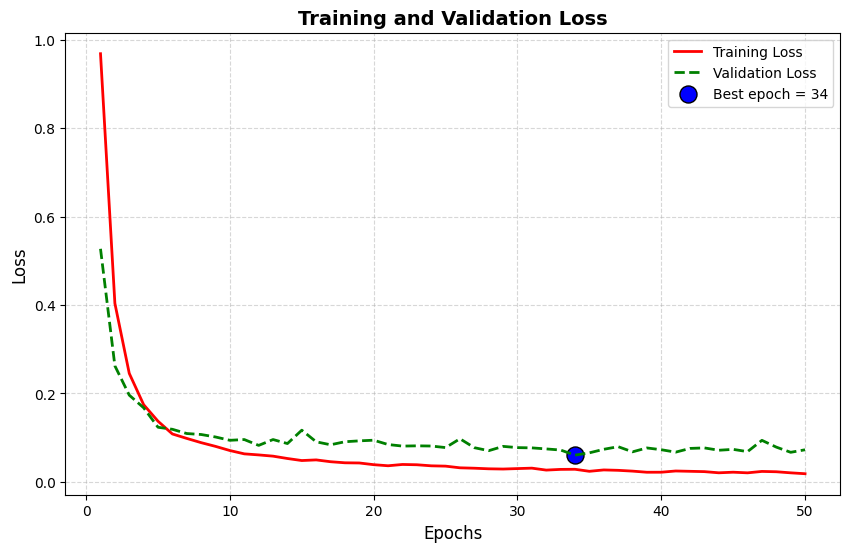

In [26]:
best_epoch_loss = np.argmin(val_loss)
best_val_loss = val_loss[best_epoch_loss]

plt.figure(figsize=(10, 6))
plt.plot(epochs, tr_loss, color='red', label='Training Loss', linewidth=2)
plt.plot(epochs, val_loss, color='green', label='Validation Loss', linestyle='--', linewidth=2)
plt.scatter(best_epoch_loss + 1, best_val_loss, s=150, c='blue',
            label=f'Best epoch = {best_epoch_loss + 1}', edgecolors='black')
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

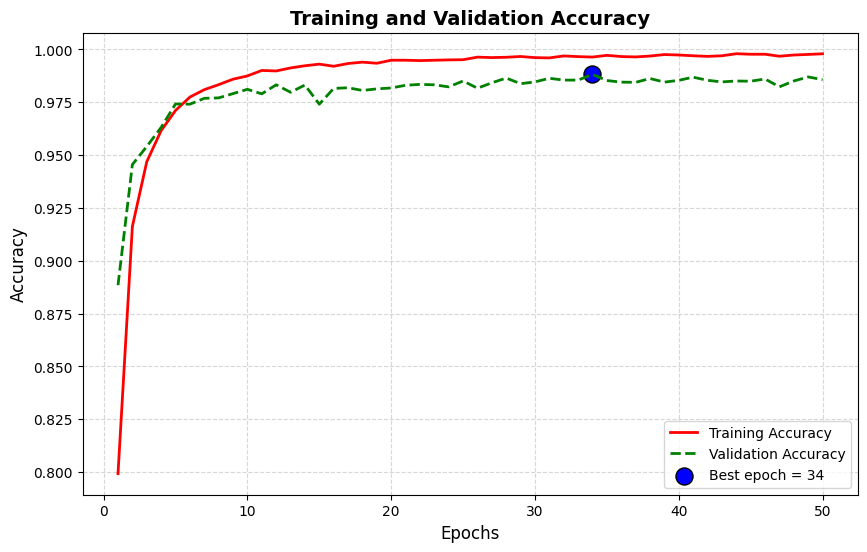

In [27]:
best_epoch_acc = np.argmax(val_acc)
best_val_acc = val_acc[best_epoch_acc]

plt.figure(figsize=(10, 6))
plt.plot(epochs, tr_acc, color='red', label='Training Accuracy', linewidth=2)
plt.plot(epochs, val_acc, color='green', label='Validation Accuracy', linestyle='--', linewidth=2)
plt.scatter(best_epoch_acc + 1, best_val_acc, s=150, c='blue',
            label=f'Best epoch = {best_epoch_acc + 1}', edgecolors='black')
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()


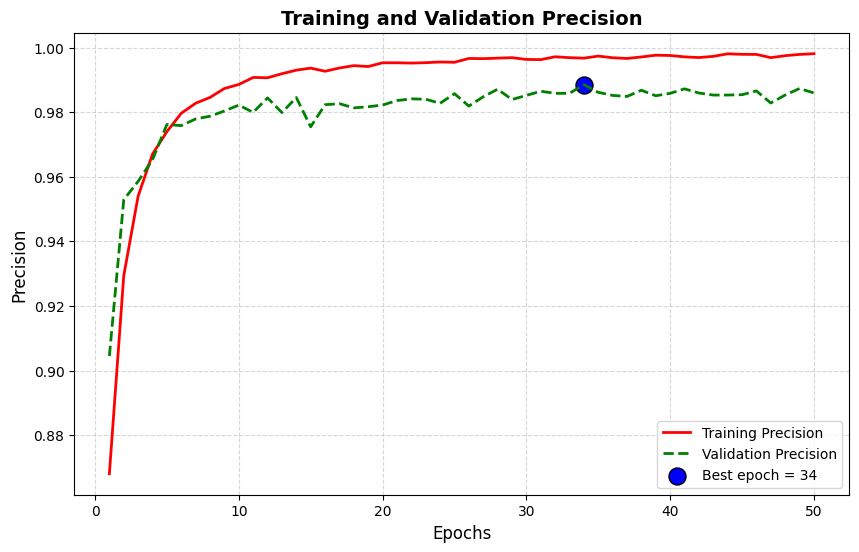

In [28]:
best_epoch_prec = np.argmax(val_precision)
best_val_prec = val_precision[best_epoch_prec]

plt.figure(figsize=(10, 6))
plt.plot(epochs, tr_precision, color='red', label='Training Precision', linewidth=2)
plt.plot(epochs, val_precision, color='green', label='Validation Precision', linestyle='--', linewidth=2)
plt.scatter(best_epoch_prec + 1, best_val_prec, s=150, c='blue',
            label=f'Best epoch = {best_epoch_prec + 1}', edgecolors='black')
plt.title('Training and Validation Precision', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()


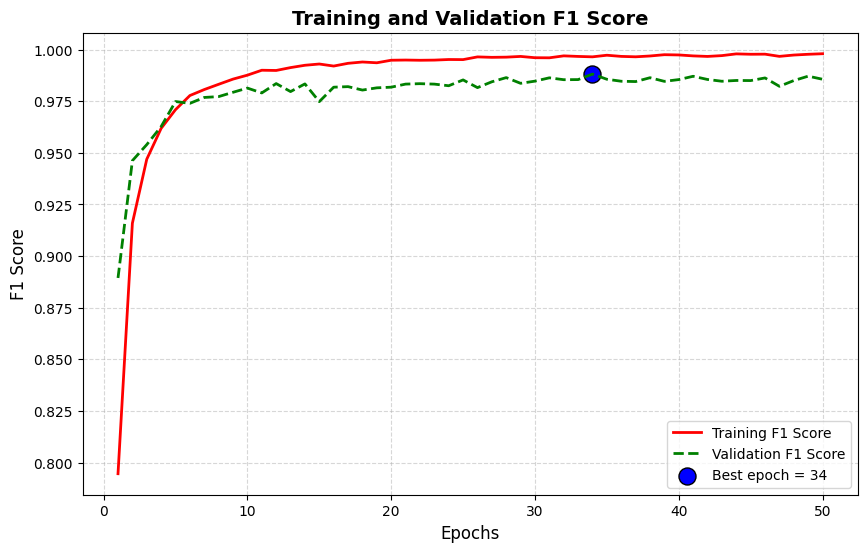

In [29]:
best_epoch_f1 = np.argmax(val_f1)
best_val_f1 = val_f1[best_epoch_f1]

plt.figure(figsize=(10, 6))
plt.plot(epochs, tr_f1, color='red', label='Training F1 Score', linewidth=2)
plt.plot(epochs, val_f1, color='green', label='Validation F1 Score', linestyle='--', linewidth=2)
plt.scatter(best_epoch_f1 + 1, best_val_f1, s=150, c='blue',
            label=f'Best epoch = {best_epoch_f1 + 1}', edgecolors='black')
plt.title('Training and Validation F1 Score', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

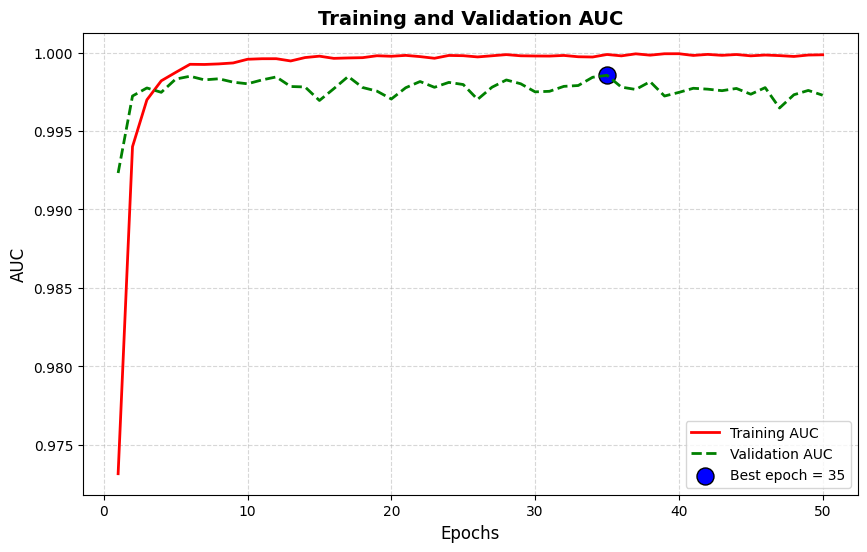

In [30]:
best_epoch_auc = np.argmax(val_auc)
best_val_auc = val_auc[best_epoch_auc]

plt.figure(figsize=(10, 6))
plt.plot(epochs, tr_auc, color='red', label='Training AUC', linewidth=2)
plt.plot(epochs, val_auc, color='green', label='Validation AUC', linestyle='--', linewidth=2)
plt.scatter(best_epoch_auc + 1, best_val_auc, s=150, c='blue',
            label=f'Best epoch = {best_epoch_auc + 1}', edgecolors='black')
plt.title('Training and Validation AUC', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

In [31]:
def evaluate_model(model, test_data, labels, model_name, test_dataframe, batch_size=BATCH_SIZE):
    """
    Evaluate a trained Keras model using a test data generator.

    Args:
        model (Model): Trained Keras model.
        test_data (Iterator): A Keras data generator for testing.
        labels (List[str]): Class label names.
        model_name (str): Name of the model (for display).
        test_dataframe (pd.DataFrame): DataFrame with test samples (for step calculation).
        batch_size (int): Batch size used in the test_data generator.

    Returns:
        Tuple[dict, dict]: 
            - Dictionary containing accuracy, precision, recall, F1 score, and AUC.
            - Dictionary of AUC curve data {class_label: (fpr, tpr)} for ROC plotting.
    """

    # Calculate steps needed for full evaluation
    steps = math.ceil(len(test_dataframe) / batch_size)

    y_true = []
    y_pred = []
    y_probs = []

    # Loop through batches and collect predictions and true labels
    for _ in tqdm(range(steps), desc=f"Evaluating {model_name}"):
        images, labels_batch = next(test_data)

        preds = model.predict(images, verbose=0)            # Predicted probabilities
        y_probs.extend(preds)                               # Save for AUC

        y_pred.extend(np.argmax(preds, axis=-1))            # Predicted class indices
        y_true.extend(np.argmax(labels_batch, axis=-1))     # True class indices

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    # Calculate performance metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    f1 = f1_score(y_true, y_pred, average="weighted")

    try:
        auc = roc_auc_score(y_true, y_probs, multi_class='ovr', average='weighted')
    except ValueError:
        auc = float('nan')

    # Generate classification report
    report = classification_report(y_true, y_pred, target_names=labels)

    # Print summary metrics
    print(f"--- {model_name} ---")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}\n")
    print("Classification Report:\n")
    print(report)

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=labels, yticklabels=labels,
        annot_kws={'size': 14}, cbar=True, linewidths=0.5, linecolor='gray',
        cbar_kws={'shrink': 0.8}
    )
    plt.title(f'Confusion Matrix: {model_name}', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=14, fontweight='bold')
    plt.xticks(fontsize=12, rotation=45 if len(labels) > 10 else 0)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

    # Compute ROC curve data per class
    auc_curve_data = {}
    try:
        for i, label in enumerate(labels):
            fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_probs[:, i])
            auc_curve_data[label] = (fpr, tpr)
    except Exception:
        auc_curve_data = {}

    return {
        "model_name": model_name,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "auc": auc
    }, auc_curve_data


Evaluating Proposed CBAM-Xception-DermNet: 100%|██████████| 147/147 [01:27<00:00,  1.69it/s]


--- Proposed CBAM-Xception-DermNet ---
Accuracy : 0.9862
Precision: 0.9862
Recall   : 0.9862
F1 Score : 0.9861
AUC      : 0.9997

Classification Report:

              precision    recall  f1-score   support

       akiec       1.00      1.00      1.00       670
         bcc       0.99      1.00      0.99       670
         bkl       0.97      0.99      0.98       671
          df       1.00      1.00      1.00       671
         mel       0.96      0.98      0.97       671
          nv       0.98      0.94      0.96       670
        vasc       1.00      1.00      1.00       671

    accuracy                           0.99      4694
   macro avg       0.99      0.99      0.99      4694
weighted avg       0.99      0.99      0.99      4694



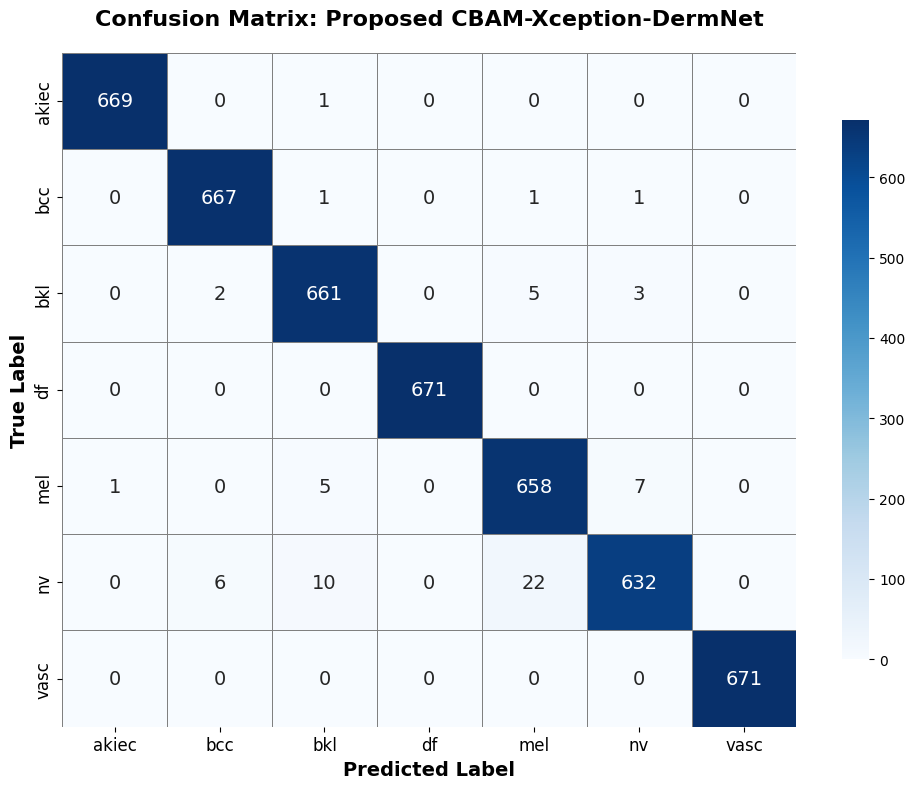

In [32]:
results, auc_curve_data = evaluate_model(model, test_data, labels, "Proposed CBAM-Xception-DermNet", test_dataframe)

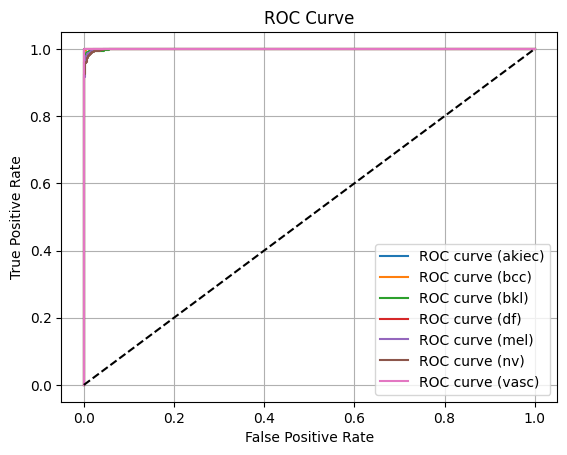

In [33]:
# Plotting the ROC curve
for label, (fpr, tpr) in auc_curve_data.items():
    plt.plot(fpr, tpr, label=f'ROC curve ({label})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
# Preprocessing wrapper
def preprocessed_image_for_cbam_visualization(img_path, target_size=(224, 224)):
    """Load and preprocess image for CBAM visualization."""
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = preprocess_image(img_array)
    img_array = np.expand_dims(img_array, axis=0)  
    return img_array, (img_array[0] * 255).astype(np.uint8)


In [35]:
# CBAM visualization function
def visualize_cbam_attention(model, img_path, layer_name):
    """
    Visualizes the CBAM attention map overlay on the input image.

    Args:
        model: Trained Keras model with CBAM layers.
        img_path: Path to the input image.
        layer_name: Name of the CBAM attention layer to extract.
    """
    # 1. Load and preprocess image
    img_tensor, orig_img = preprocessed_image_for_cbam_visualization(img_path)

    # 2. Create submodel to extract CBAM output
    cbam_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    # 3. Predict to get attention map
    cbam_output = cbam_model.predict(img_tensor, verbose=0)

    # 4. Compute average over channels
    attention_map = np.mean(cbam_output[0], axis=-1)

    # 5. Normalize attention map to [0, 1]
    attention_map -= np.min(attention_map)
    attention_map /= (np.max(attention_map) + 1e-8)

    # 6. Resize to original image size
    attention_map_resized = cv2.resize(attention_map, (orig_img.shape[1], orig_img.shape[0]))

    # 7. Apply colormap
    heatmap = cv2.applyColorMap(np.uint8(255 * attention_map_resized), cv2.COLORMAP_JET)

    # 8. Overlay on image
    overlay = cv2.addWeighted(orig_img, 0.6, heatmap, 0.4, 0)

    # 9. Plot results
    plt.figure(figsize=(10, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(orig_img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title('CBAM Attention Overlay')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


spatial_attention


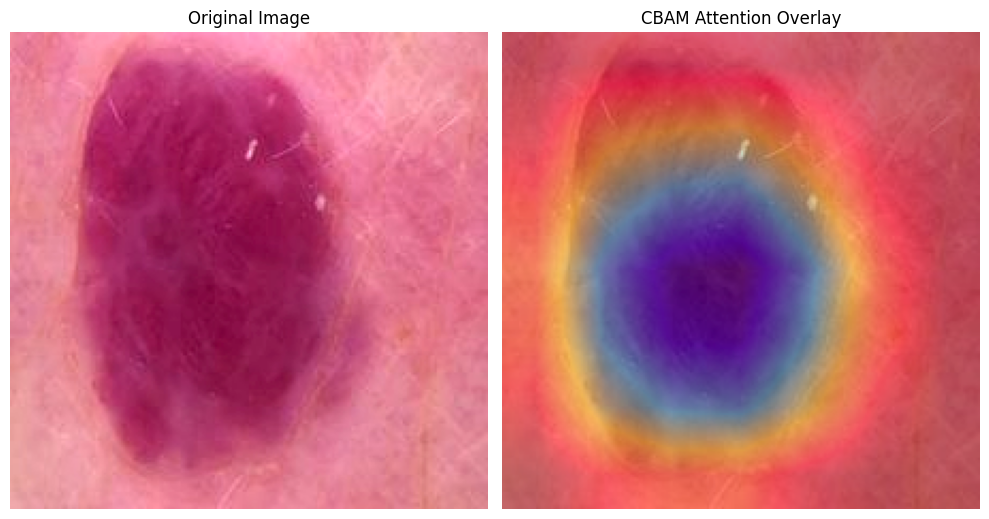

In [36]:
SpatialAttention_Layer_Name = None  
found = False  

for i, layer in enumerate(model.layers):
    if hasattr(layer, 'name') and "spatial_attention" in layer.name:
        SpatialAttention_Layer_Name = layer.name
        found = True

if found:
    print(SpatialAttention_Layer_Name)
    visualize_cbam_attention(model, r"HAM10000_organized\vasc\ISIC_0024662.jpg", SpatialAttention_Layer_Name)
else:
    print("No layers with 'spatial_attention' found.")


In [37]:
# Load and preprocess image for model input and visualization
def preprocessing_image_for_gradcam(img_path, target_size=(224, 224)):
    """
    Function to load and preprocess an image for Grad-CAM.
    
    Args:
        img_path: Path to the input image file.
        target_size: Desired target size for the image (default is 224x224).
    
    Returns:
        img_array: Preprocessed image array for model input.
        img_array[0]: Original image array (for visualization).
    """
    
    # 1. Load the image from the provided path, resizing it to the target size
    img = image.load_img(img_path, target_size=target_size)
    
    # 2. Convert the loaded image to a numpy array
    img_array = image.img_to_array(img)
    
    # 3. Preprocess the image (e.g., normalization, scaling)
    img_array = preprocess_image(img_array)
    
    # 4. Add an extra dimension to the image array to match the model input shape (batch_size, height, width, channels)
    img_array = np.expand_dims(img_array, axis=0)
    
    # 5. Convert the image array to a TensorFlow tensor with float32 type
    img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)
    
    # 6. Return both the preprocessed image array and the original image array for visualization
    return img_array, img_array[0].numpy()


In [38]:
# Compute Grad-CAM++ heatmap for a given model, image tensor, and target layer
def compute_gradcam_plus_plus(model, img_tensor, conv_layer, class_index=None):
    """
    Function to compute Grad-CAM++ heatmap for a given model and image tensor.
    Args:
        model: Trained model for which Grad-CAM++ is computed.
        img_tensor: Input image tensor for which Grad-CAM++ is to be computed.
        conv_layer: The convolutional layer from which feature maps are extracted.
        class_index: (Optional) Target class index to compute the Grad-CAM++ for.
                      If None, the index of the highest predicted class is used.
    
    Returns:
        cam: Grad-CAM++ heatmap corresponding to the input image.
    """
    
    # 1. Create a sub-model that outputs both convolutional feature maps and final predictions
    grad_model = Model(inputs=model.inputs, outputs=[conv_layer.output, model.output])
    
    # 2. Start recording gradients for higher-order derivatives using GradientTape
    with tf.GradientTape(persistent=True) as gtape1:
        with tf.GradientTape(persistent=True) as gtape2:
            with tf.GradientTape() as gtape3:
                # Get convolutional outputs and predictions
                conv_outputs, predictions = grad_model(img_tensor)
                
                # If class_index is not provided, use the class with the highest prediction
                if class_index is None:
                    class_index = tf.argmax(predictions[0])
                
                # Compute loss for the target class
                loss = predictions[:, class_index]
            
            # 3. Compute first-order gradients (∂L/∂F) for the feature map
            grads = gtape3.gradient(loss, conv_outputs)
            if grads is None:
                raise ValueError("First-order gradients could not be computed.")

        # 4. Compute second-order gradients (∂²L/∂F²) for the feature map
        grads2 = gtape2.gradient(grads, conv_outputs)
        if grads2 is None:
            raise ValueError("Second-order gradients could not be computed.")

    # 5. Compute third-order gradients (∂³L/∂F³) for the feature map
    grads3 = gtape1.gradient(grads2, conv_outputs)
    if grads3 is None:
        raise ValueError("Third-order gradients could not be computed.")
    
    # 6. Compute the global sum across spatial dimensions of the feature maps
    global_sum = tf.reduce_sum(conv_outputs, axis=(1, 2), keepdims=True)
    
    # 7. Compute alpha weights (α) based on second- and third-order gradients
    alpha_num = grads2
    alpha_denom = grads2 * 2.0 + grads3 * global_sum
    alpha_denom = tf.where(alpha_denom != 0.0, alpha_denom, tf.ones_like(alpha_denom))  # Avoid division by zero
    alphas = alpha_num / alpha_denom

    # 8. Normalize α weights (alphas) to ensure the values sum up to 1
    alpha_norm_const = tf.reduce_sum(alphas * tf.nn.relu(grads), axis=(1, 2), keepdims=True)
    alphas /= (alpha_norm_const + 1e-10)

    # 9. Compute weighted sum of feature maps using α weights and first-order gradients
    weights = tf.reduce_sum(alphas * tf.nn.relu(grads), axis=(1, 2))
    cam = tf.reduce_sum(weights[:, tf.newaxis, tf.newaxis, :] * conv_outputs, axis=-1)
    
    # 10. Squeeze unnecessary dimensions and ensure non-negative values for CAM
    cam = tf.squeeze(cam)
    cam = np.maximum(cam, 0)

    # 11. Resize the CAM to match the input image size (224x224 or same dimensions as the input tensor)
    cam = cv2.resize(cam, (img_tensor.shape[2], img_tensor.shape[1]))

    # 12. Normalize the CAM values to the range [0, 1]
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    return cam


In [39]:
# Display Grad-CAM++ heatmap on image
def display_gradcam(model, img_path, layer_name='block14_sepconv2_act'):
    """
    Visualizes the Grad-CAM++ heatmap overlay on the original image and compares it side by side.
    
    Args:
        model: Trained Keras model.
        img_path: Path to the image to analyze.
        layer_name: Name of the convolutional layer to use for Grad-CAM++.
    """
    # 1. Load and preprocess the image
    input_tensor, _ = preprocessing_image_for_gradcam(img_path)

    # 2. Get the convolutional layer by name
    conv_layer = model.get_layer(layer_name)

    # 3. Generate Grad-CAM++ heatmap
    heatmap = compute_gradcam_plus_plus(model, input_tensor, conv_layer)

    # 4. Load original image using OpenCV and resize to match Grad-CAM++ heatmap size
    orig = cv2.imread(img_path)
    orig = cv2.resize(orig, (224, 224))  # Resize original image to (224, 224)

    # 5. Resize heatmap and apply color map
    heatmap_resized = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # 6. Superimpose heatmap onto the original image
    superimposed_img = cv2.addWeighted(orig, 0.6, heatmap_color, 0.4, 0)

    # 7. Display original vs Grad-CAM++ side by side
    plt.figure(figsize=(12, 6))

    # Left side: original image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # Right side: Grad-CAM++ overlay
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('Grad-CAM++ Overlay')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

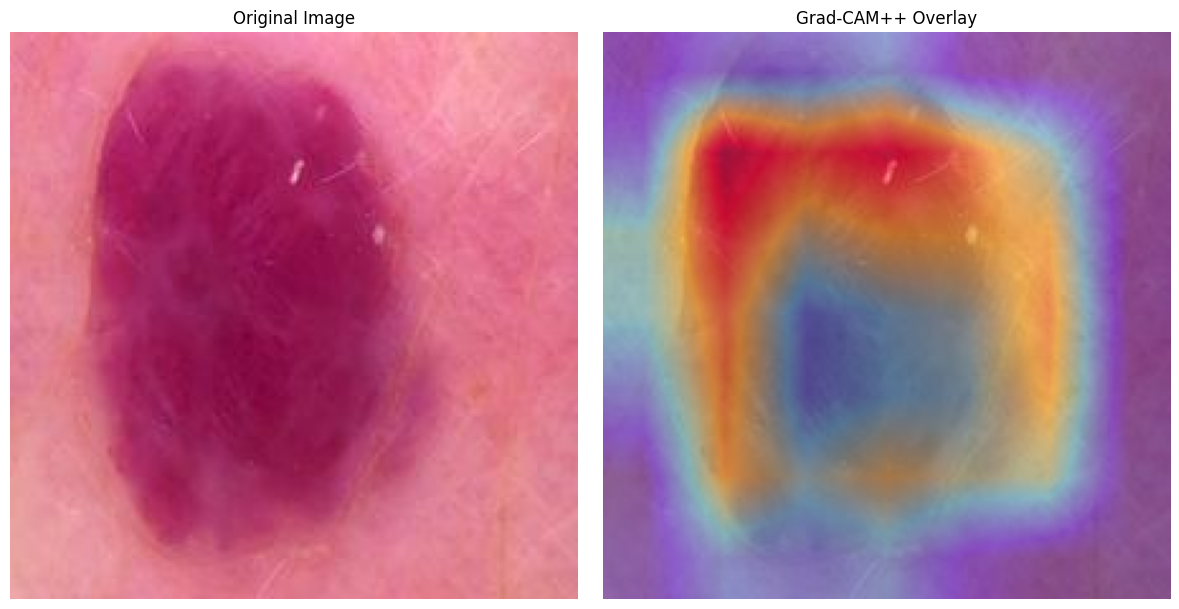

In [40]:
display_gradcam(model, r"HAM10000_organized\vasc\ISIC_0024662.jpg", layer_name="block14_sepconv2_act")